# 🧬 lncRNA-Protein Interaction Graph Analysis

This notebook documents the full process of building and analyzing a biological network that integrates lncRNA-gene and gene-gene interactions based on data from **LncTarD** and **STRING DB**.


## 1. Import Libraries

### 📦 Step 1: Importing Required Libraries
We start by importing the necessary Python packages to handle data, build graphs, and visualize.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
# 📂 Helper: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Load and Clean LncTarD Data

### 🧼 Data Preprocessing Rationale

- We filtered the STRING dataset using a **threshold of 550** on the `combined_score` column.
  This threshold is a good balance between **high confidence interactions** and retaining enough data for meaningful graph structure.
  STRING recommends 400+ for medium confidence and 700+ for high confidence; 550 sits in the confident range without excessive filtering.

- **Mapping ENSP IDs to Gene Names**:
  We used UniProt to convert STRING's ENSP identifiers to standard gene names.
  Out of 18,703 unique ENSP IDs, we successfully mapped 18,411 to gene names.

- **Handling Missing or Ambiguous Mappings**:
  - We discarded 292 ENSP IDs that had no mapping on UniProt.
  - For ENSP IDs with multiple gene name mappings, we selected the **most commonly recognized** gene name (the primary entry).

- **Null Cleanup**:
  Any row in the dataset with a missing `node1` or `node2` value was excluded from the final graph to ensure consistency and completeness.

### 🧬 Step 2: Load LncTarD Dataset
We load the LncTarD dataset which contains regulatory interactions between lncRNAs and protein-coding genes.

In [12]:
# Load lncRNA-gene interactions with disease info
lnctard_df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/lncRNA_Graph_Project/data/lncRNA_Associated_Genes_AutoFilled.xlsx")

# Rename and keep relevant columns
lnctard_df = lnctard_df.rename(columns={
     "Regulator": "node1",
     "Target": "node2",
     "regulatoryType": "interaction",
     "DiseaseName": "disease"
})
lnctard_df["source"] = "lncRNA"
lnctard_df = lnctard_df.dropna(subset=["node1", "node2"])

columns_to_keep = ['node1', 'node2', 'interaction', 'disease']
lnctard_df = lnctard_df[columns_to_keep]

# 👀 Show first few rows after cleanup
lnctard_df.head()


,node1,node2,interaction,disease
0,LINC00313,miR-4429,binding/interaction,Papillary thyroid carcinoma
1,FAM83H-AS1,CDKN1A,regulation,Malignant glioma
2,NEAT1,TGFB1,association,Hepatocellular carcinoma
3,NEAT1,ZEB1,regulation,Breast cancer
4,ZFPM2-AS1,MIF,binding/interaction,Gastric cancer


## 3. Load and Clean STRING Data

### 🔗 Step 3: Load STRING Dataset
We import STRING protein-protein interaction data that was pre-filtered and mapped to gene names.

In [9]:
# Load STRING gene-gene interactions (after ENSP to gene mapping)
string_df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/lncRNA_Graph_Project/data/STRING_gene_gene_final.xlsx")
string_df = string_df.rename(columns={
    "gene1": "node1",
    "gene2": "node2",
    "combined_score": "interaction"
})
string_df["source"] = "PPI"
string_df["disease"] = None
string_df = string_df.dropna(subset=["node1", "node2"])
# 👀 Preview loaded data
string_df.head()

,node1,node2,interaction,source,disease
0,ARF5,GGA1,594,PPI,None
1,M6PR,GGA1,957,PPI,None
2,SUPT16H,GGA1,550,PPI,None
3,CSNK2A1,GGA1,825,PPI,None
4,RNF11,GGA1,563,PPI,None


## 4. Merge Both Datasets

### 🧩 Step 4: Merge Datasets
We merge both lncRNA-protein and protein-protein interactions into one comprehensive DataFrame.

In [13]:
# Combine both datasets
combined_df = pd.concat([lnctard_df, string_df], ignore_index=True)
combined_df.to_excel("/content/drive/MyDrive/Colab Notebooks/lncRNA_Graph_Project/data/Final_Graph_Interactions_With_Disease.xlsx", index=False)
combined_df.head()

,node1,node2,interaction,disease,source
0,LINC00313,miR-4429,binding/interaction,Papillary thyroid carcinoma,NaN
1,FAM83H-AS1,CDKN1A,regulation,Malignant glioma,NaN
2,NEAT1,TGFB1,association,Hepatocellular carcinoma,NaN
3,NEAT1,ZEB1,regulation,Breast cancer,NaN
4,ZFPM2-AS1,MIF,binding/interaction,Gastric cancer,NaN


## 5. Build the Graph and Analyze

### 🧱 Step 5: Build the Graph
We create an undirected graph from the combined data and add nodes and edges with biological attributes.

In [18]:
G = nx.Graph()

for _, row in combined_df.iterrows():
    G.add_node(row["node1"], type="lncRNA" if row["source"] == "lncRNA" else "protein")
    G.add_node(row["node2"], type="protein")
    G.add_edge(row["node1"], row["node2"], interaction=row["interaction"], disease=row["disease"])

# Graph metrics
print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())

components = list(nx.connected_components(G))
print("Connected components:", len(components))
print("Largest component size:", len(max(components, key=len)))

avg_deg = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", round(avg_deg, 2))
print("Density:", round(nx.density(G), 4))
print("\nTop 10 high-degree nodes:")

# top central nodes (degree)
top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in top_nodes:
    print(f"{node}: {degree}")

Total nodes: 20315
Total edges: 437793
Connected components: 75
Largest component size: 20162
Average degree: 43.1
Density: 0.0021

Top 10 high-degree nodes:
TP53: 1345
AKT1: 962
CTNNB1: 931
EGFR: 930
ACTB: 874
PRKACA: 826
MYC: 823
SRC: 818
TNF: 806
PRKACB: 803


### 🧪 Step 7: Visualize a Subgraph
To get a better understanding of the graph structure, we visualize a small part of the graph.
This helps us confirm the connections and get a qualitative feel for the data.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


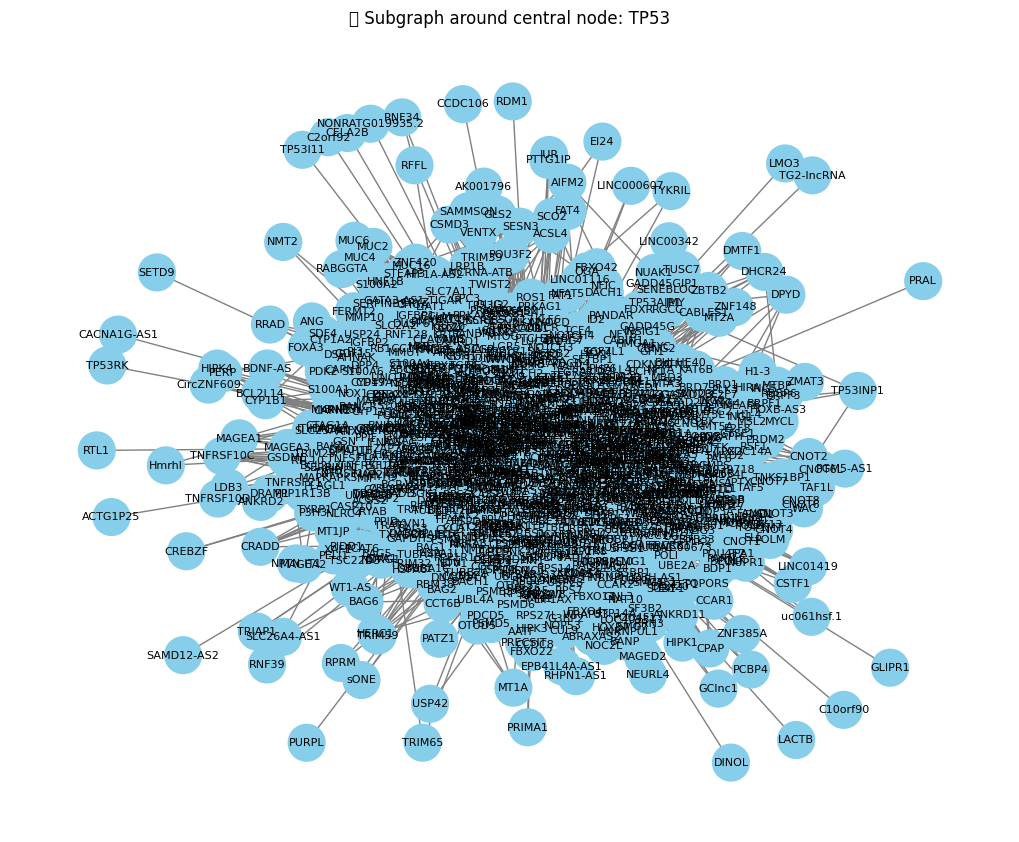

In [19]:
# 🧪 Improved Subgraph Visualization: draw neighbors of a central hub node

# Select a central hub node to visualize its neighborhood
central_node = "TP53"

# Get all nodes directly connected to the central node (its neighbors)
neighbors = list(G.neighbors(central_node))

# Include the central node itself
sub_nodes = [central_node] + neighbors

# Create the subgraph based on selected nodes
subgraph = G.subgraph(sub_nodes)

# Assign node colors based on type (lncRNA vs protein)
color_map = ['orange' if subgraph.nodes[n]['type'] == 'lncRNA' else 'skyblue' for n in subgraph.nodes]

# Draw the subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(
    subgraph, pos,
    with_labels=True,
    node_color=color_map,
    node_size=700,
    font_size=8,
    edge_color='gray'
)
plt.title(f"🔍 Subgraph around central node: {central_node}")
plt.show()


### 📈 Step 8: Analyze Degree Distribution
We analyze the degree distribution to understand how connections are spread across the graph.
This gives us insight into hub nodes and possible scale-free behavior.

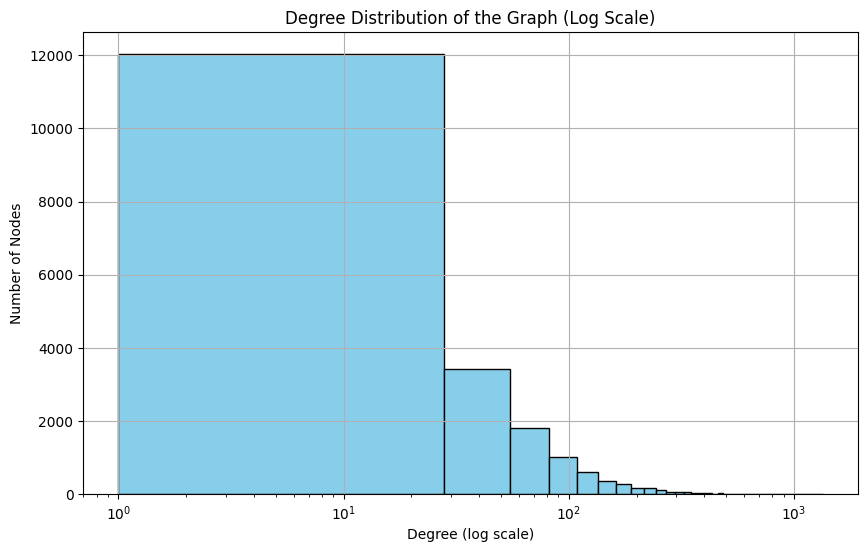

In [20]:
# 📈 Improved Degree Distribution Visualization with log scale

# Calculate degrees
degrees = dict(G.degree())
degree_values = list(degrees.values())

# Plot histogram with log scale on X-axis
plt.figure(figsize=(10, 6))
plt.hist(degree_values, bins=50, color='skyblue', edgecolor='black')
plt.xscale('log')
plt.title("Degree Distribution of the Graph (Log Scale)")
plt.xlabel("Degree (log scale)")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()


### 🧠 Final Notes
- The graph has a **dense core** with hub proteins like TP53, AKT1, etc.
- **lncRNAs tend to be sparsely connected**, regulating a few proteins each.
- The network is **highly connected** with a large giant component.
- The structure is suitable for **Graph Neural Network (GNN)** applications.

📌 This notebook serves as a complete pipeline from raw data to biological network analysis.